In [1]:
import sys
sys.path.append('..')
import itertools, copy
import re
import json
import numpy as np
import scipy.misc
from scipy.stats import binom
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy.testing as npt

plt.style.use('../peptidome.mplstyle')

from lib import *
from lib.maxent import *

from numba import njit

%load_ext autoreload
%autoreload 2

In [2]:
L = 9
datasets = ['train', 'test', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  load_matrix('../maxent/data/%s_matrix_L%i.csv.gz' % (dataset, L))

In [3]:
q = naminoacids

In [4]:
aacounts = to_aacounts(sample_matrices['train'])

In [5]:
cov_kmer = np.cov(aacounts.T/L)

In [6]:
arr = np.load('../aafreqpca/data/data.npz')
aa_human = arr['human']
cov_protein = np.cov(aa_human.T)

In [7]:
fi = np.mean(aacounts/L, axis=0)

In [8]:
cov_multinomial = np.zeros_like(cov_kmer)
for i in range(q):
    for j in range(q):
        if i == j:
            cov_multinomial[i, i] = fi[i]*(1-fi[i])/L
        else:
            cov_multinomial[i, j] = -fi[i]*fi[j]/L

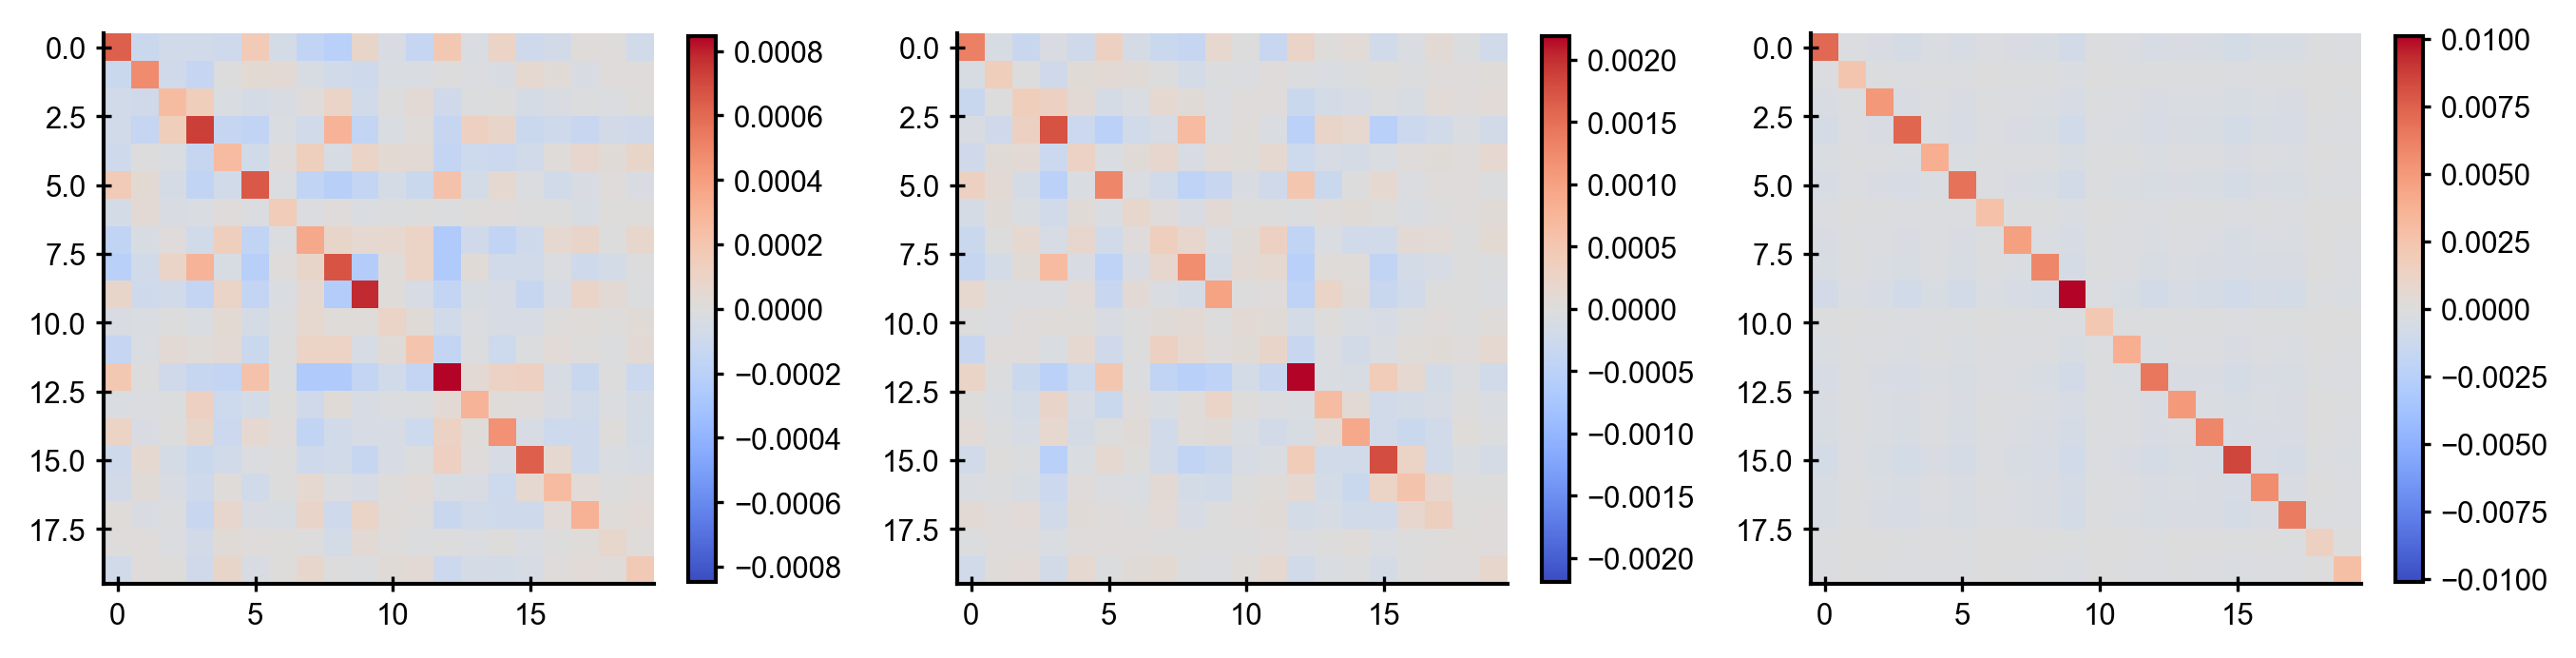

In [9]:
fig, axes = plt.subplots(figsize=(9, 3), ncols=3)
for i, matrix in enumerate([cov_protein, cov_kmer-cov_multinomial, cov_multinomial]):
    ax = axes[i]
    im = ax.imshow(matrix, vmin=-matrix.max(), vmax=matrix.max(), cmap='coolwarm')
    fig.colorbar(im, ax=ax, shrink=0.7)
fig.tight_layout()

0.8338968859181958 3.1342288456311137e-157 1.8816198601520313


Text(0.05, 1.0, 'slope$=1.88$\n$r^2=0.83$')

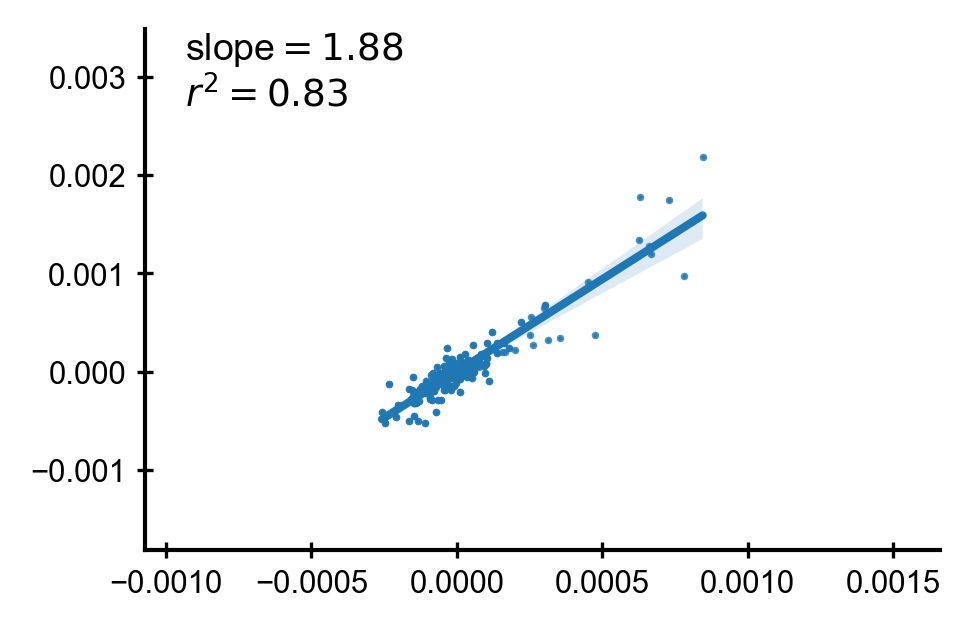

In [10]:
fig, ax = plt.subplots()
x = cov_protein.flatten()
y = (cov_kmer - cov_multinomial).flatten()
sns.regplot(x, y, ax=ax, scatter_kws=dict(s=1))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2, p_value, slope)
ax.text(0.05, 1.0, 'slope$={1:.2f}$\n$r^2={0:.2f}$'.format(r_value**2, slope),
        va='top', ha='left', transform=ax.transAxes)

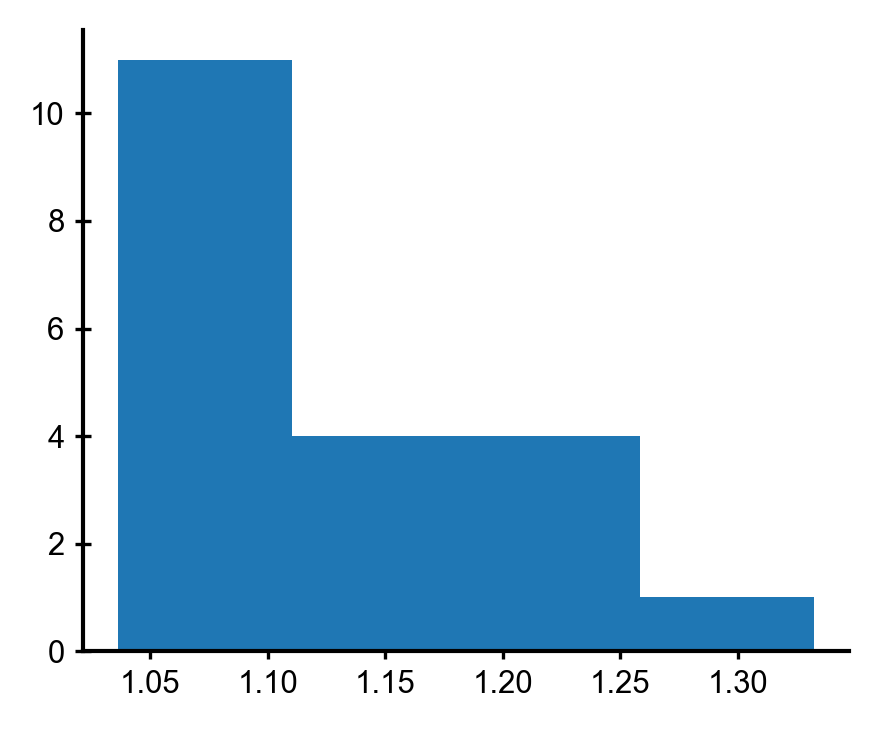

In [11]:
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.hist(np.diag(cov_kmer/cov_multinomial), bins=4)
fig.tight_layout()

# Maxent fitting

In [12]:
n1 = calc_n1(aacounts)
n1

array([0.63160537, 0.20116395, 0.43189682, 0.63882889, 0.32990002,
       0.59293757, 0.22709944, 0.39747958, 0.50522771, 0.90904145,
       0.18091782, 0.32592778, 0.56904603, 0.42765345, 0.50409083,
       0.74833342, 0.48167295, 0.54522752, 0.11091272, 0.24103668])

In [14]:
n2 = calc_n2(aacounts)

In [15]:
npt.assert_allclose(cov_kmer, (n2 - np.outer(n1, n1))/L**2, atol=1e-8)

In [16]:
x0 = np.random.randint(q, size=L)
energy_cov(x0, np.ones(q), np.zeros((q, q)))

-9.0

In [17]:
def fit_cov(n1, n2, L, sampler, q=naminoacids,
            niter=1, epsilon=0.1, pseudocount=1.0,
            prng=None, output=False):
    """ sampler(x0, energy, jump, prng=prng): function returning samples from the distribution """
    if prng is None:
        prng = np.random
    h = np.log(n1/L)
    h -= np.mean(h)
    J = np.zeros_like(n2)
    for iteration in range(niter):
        if output:
            print('iteration %g/%g'%(iteration+1,niter))

        x0 = global_jump(np.zeros(L), q, prng=prng)
        
        @njit
        def jump(x):
            return local_jump_jit(x, q)
        @njit
        def energy(x):
            return energy_cov(x, h, J)

        samples = sampler(x0, energy, jump)
        aacounts = to_aacounts(samples)

        n1_model = calc_n1(aacounts)
        n2_model = calc_n2(aacounts)
 
        h -= np.log(n1_model/n1)*epsilon
        J -= np.log(n2_model/n2)*epsilon
        #h -= (n1_model-n1)*epsilon
        #J -= (n2_model-n2)*epsilon
    return h, J

In [18]:
prng = np.random
niter = 50
stepsize = 0.05
nsample = L
nsteps = 2e5
nburnin = 1e3
output = True

In [19]:
def sampler(*args, **kwargs):
    return mcmcsampler(*args, nsteps=nsteps, nsample=nsample, nburnin=nburnin, **kwargs)
h, J = fit_cov(n1, n2, L, sampler=sampler, niter=niter,
                         epsilon=stepsize, prng=prng, output=output)

iteration 1/50
iteration 2/50
iteration 3/50
iteration 4/50
iteration 5/50
iteration 6/50
iteration 7/50
iteration 8/50
iteration 9/50
iteration 10/50
iteration 11/50
iteration 12/50
iteration 13/50
iteration 14/50
iteration 15/50
iteration 16/50
iteration 17/50
iteration 18/50
iteration 19/50
iteration 20/50
iteration 21/50
iteration 22/50
iteration 23/50
iteration 24/50
iteration 25/50
iteration 26/50
iteration 27/50
iteration 28/50
iteration 29/50
iteration 30/50
iteration 31/50
iteration 32/50
iteration 33/50
iteration 34/50
iteration 35/50
iteration 36/50
iteration 37/50
iteration 38/50
iteration 39/50
iteration 40/50
iteration 41/50
iteration 42/50
iteration 43/50
iteration 44/50
iteration 45/50
iteration 46/50
iteration 47/50
iteration 48/50
iteration 49/50
iteration 50/50


In [22]:
nsteps_generate = int(sample_matrices['train'].shape[0]*nsample)

@njit
def energy(x):
    return energy_cov(x, h, J)

@njit
def jump(x):
    return local_jump_jit(x, q)

x0 = prng.randint(q, size=L)
model_matrix = mcmcsampler(x0, energy, jump,
                           nsteps=nsteps_generate, nsample=nsample, nburnin=nburnin)
aacounts_model = to_aacounts(model_matrix)
cov_model = np.cov(aacounts_model.T/L)
n1_model = calc_n1(aacounts_model)
n2_model = calc_n2(aacounts_model)

In [23]:
np.savetxt('data/model_matrix.csv.gz', model_matrix, fmt='%i')
np.savez('data/Human_L%g.npz'%L, h=h, J=J)

In [24]:
@njit
def energy(x):
    return energy_cov(x, h, np.zeros_like(J))

model_ind = mcmcsampler(x0, energy, jump,
                        nsteps=nsteps_generate, nsample=nsample)
aacounts_ind = to_aacounts(model_ind)
cov_ind = np.cov(aacounts_ind.T/L)

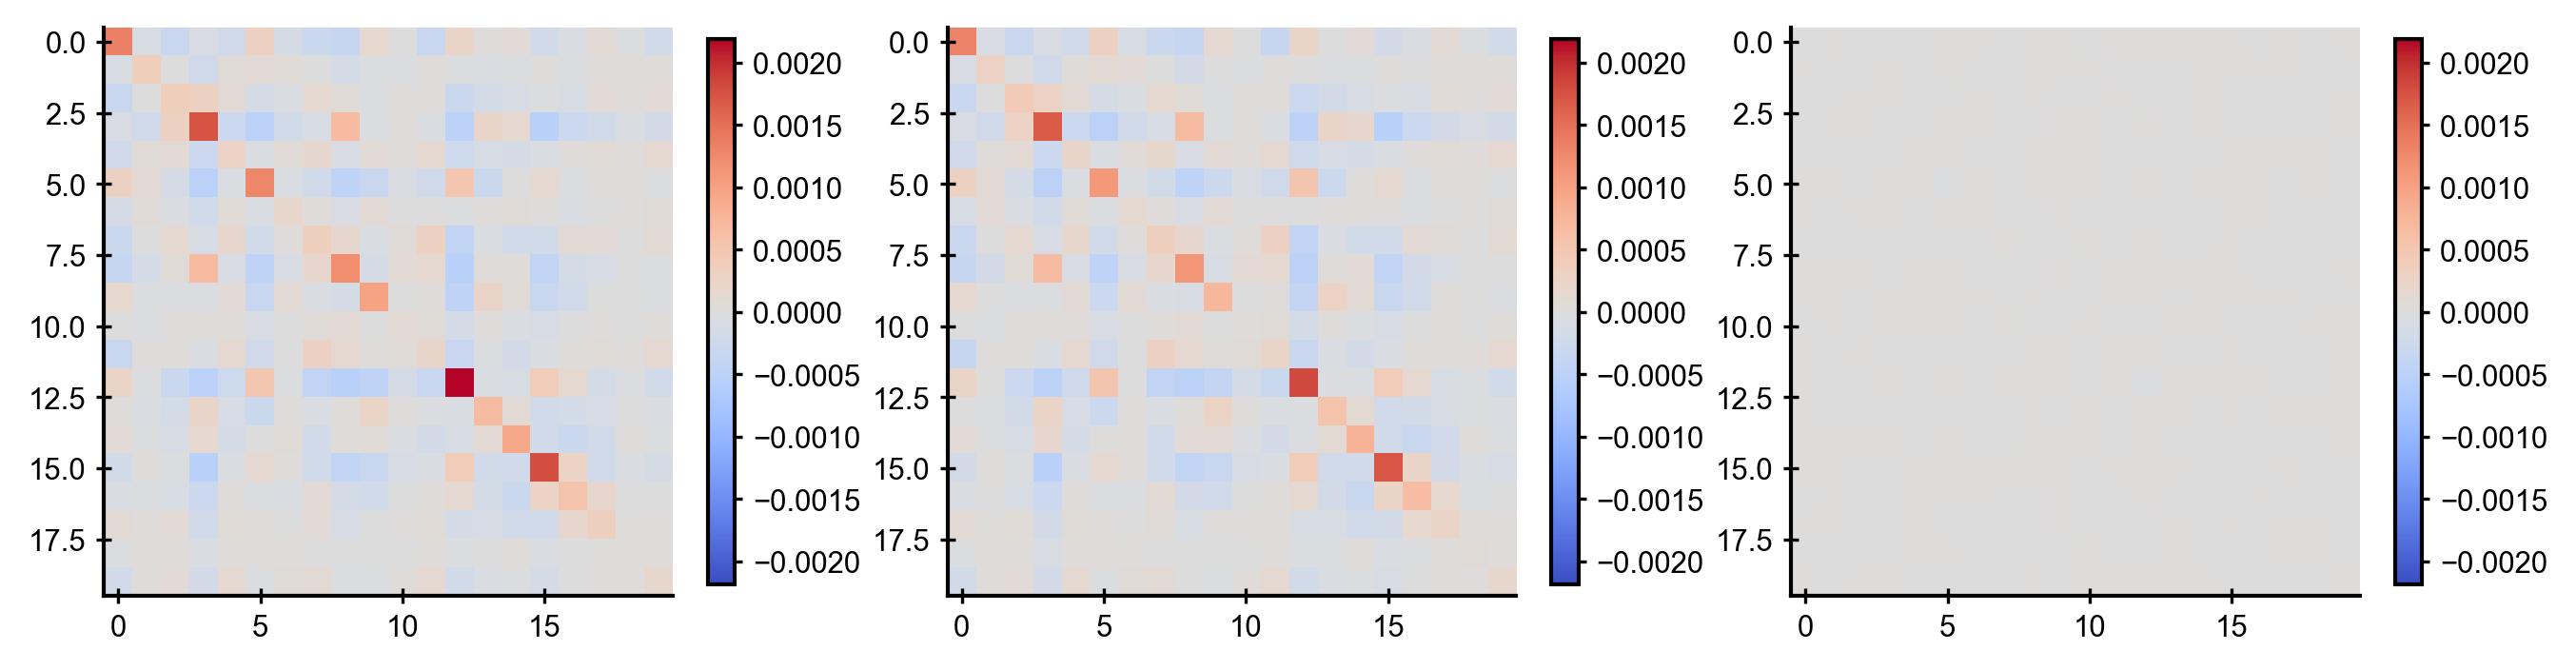

In [25]:
fig, axes = plt.subplots(figsize=(9, 3), ncols=3)
vmax = (cov_kmer-cov_multinomial).max()
for i, matrix in enumerate([cov_kmer-cov_multinomial,
                            cov_model-cov_multinomial,
                            cov_ind-cov_multinomial]):
    ax = axes[i]
    im = ax.imshow(matrix, vmin=-vmax, vmax=vmax, cmap='coolwarm')
    fig.colorbar(im, ax=ax, shrink=0.7)
fig.tight_layout()

0.9919535133524677 0.0 0.9307956024449778


Text(0.05, 1.0, 'slope$=0.93$\n$r^2=0.99$')

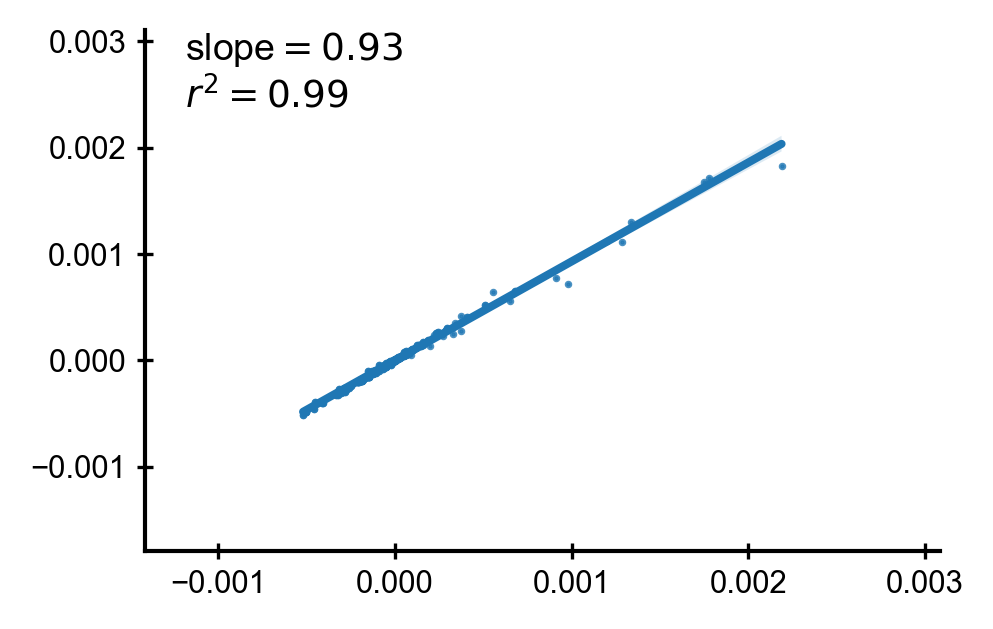

In [26]:
fig, ax = plt.subplots()
x = (cov_kmer-cov_multinomial).flatten()
y = (cov_model-cov_multinomial).flatten()
sns.regplot(x, y, ax=ax, scatter_kws=dict(s=1))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2, p_value, slope)
ax.text(0.05, 1.0, 'slope$={1:.2f}$\n$r^2={0:.2f}$'.format(r_value**2, slope),
        va='top', ha='left', transform=ax.transAxes)

0.9992588119640597 1.2524936646632855e-29 0.986280554535421


Text(0.05, 1.0, 'slope$=0.99$\n$r^2=1.00$')

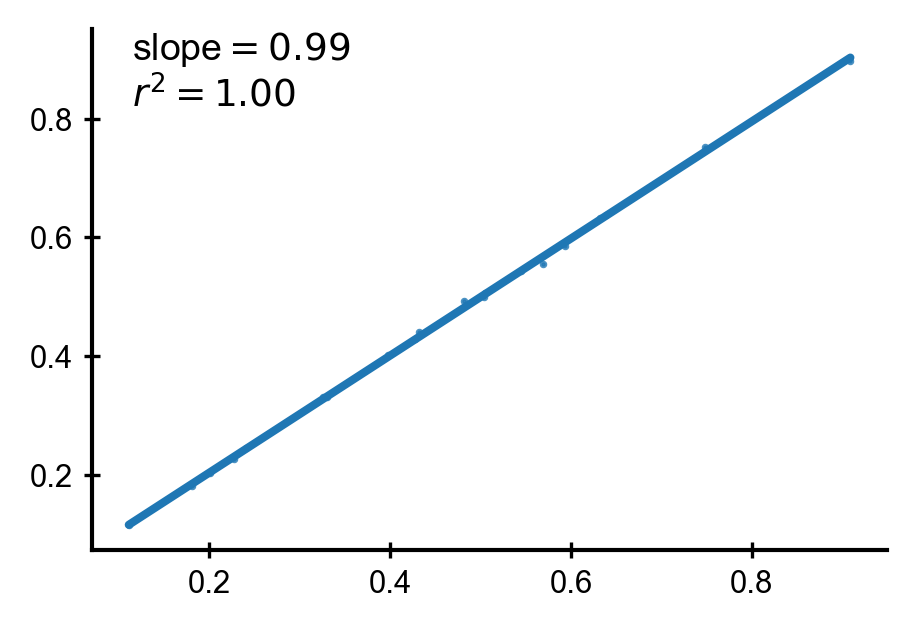

In [27]:
fig, ax = plt.subplots()
x = n1
y = n1_model
sns.regplot(x, y, ax=ax, scatter_kws=dict(s=1))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2, p_value, slope)
ax.text(0.05, 1.0, 'slope$={1:.2f}$\n$r^2={0:.2f}$'.format(r_value**2, slope),
        va='top', ha='left', transform=ax.transAxes)

0.9994860511089362 0.0 0.98518132440638


Text(0.05, 1.0, 'slope$=0.99$\n$r^2=1.00$')

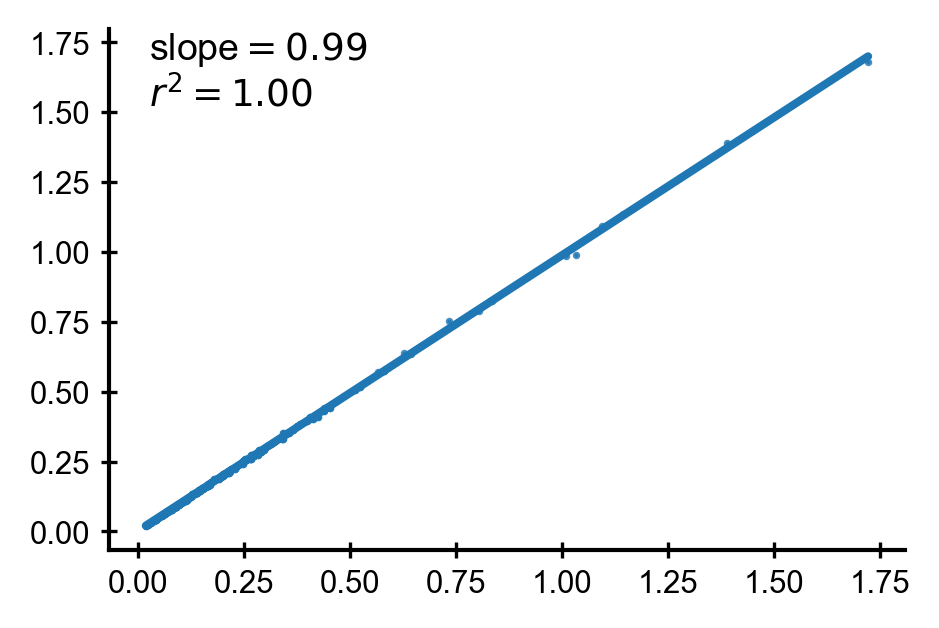

In [28]:
fig, ax = plt.subplots()
x = n2.flatten()
y = n2_model.flatten()
sns.regplot(x, y, ax=ax, scatter_kws=dict(s=1))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2, p_value, slope)
ax.text(0.05, 1.0, 'slope$={1:.2f}$\n$r^2={0:.2f}$'.format(r_value**2, slope),
        va='top', ha='left', transform=ax.transAxes)

# Compare with disordered maxent model

In [32]:
aacounts_maxent_disordered = to_aacounts(sample_matrices['model'])

In [33]:
cov_maxent_disordered = np.cov(aacounts_maxent_disordered.T/L)

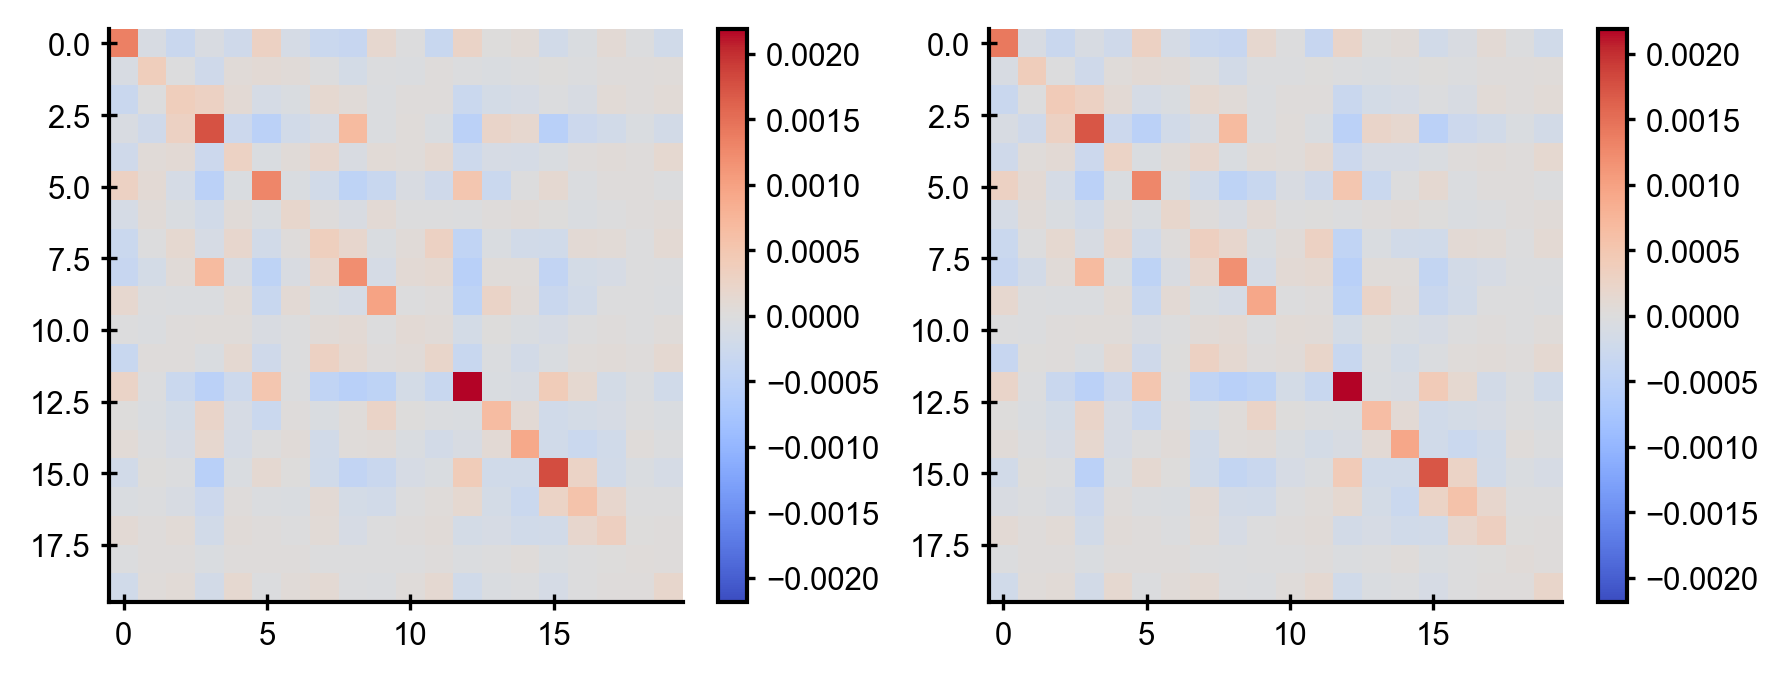

In [34]:
fig, axes = plt.subplots(figsize=(6, 3), ncols=2)
vmax = (cov_kmer-cov_multinomial).max()
for i, matrix in enumerate([cov_kmer-cov_multinomial,
                            cov_maxent_disordered-cov_multinomial]):
    ax = axes[i]
    im = ax.imshow(matrix, vmin=-vmax, vmax=vmax, cmap='coolwarm')
    fig.colorbar(im, ax=ax, shrink=0.7)
fig.tight_layout()

In [35]:
params = np.load('../maxent/data/Human_9.npz')
hi = params['hi']
Jij = params['Jij']

0.9988577406112923 6.143007015022327e-28 1.0143513489458438


Text(0.05, 1.0, 'slope$=1.01$\n$r^2=1.00$')

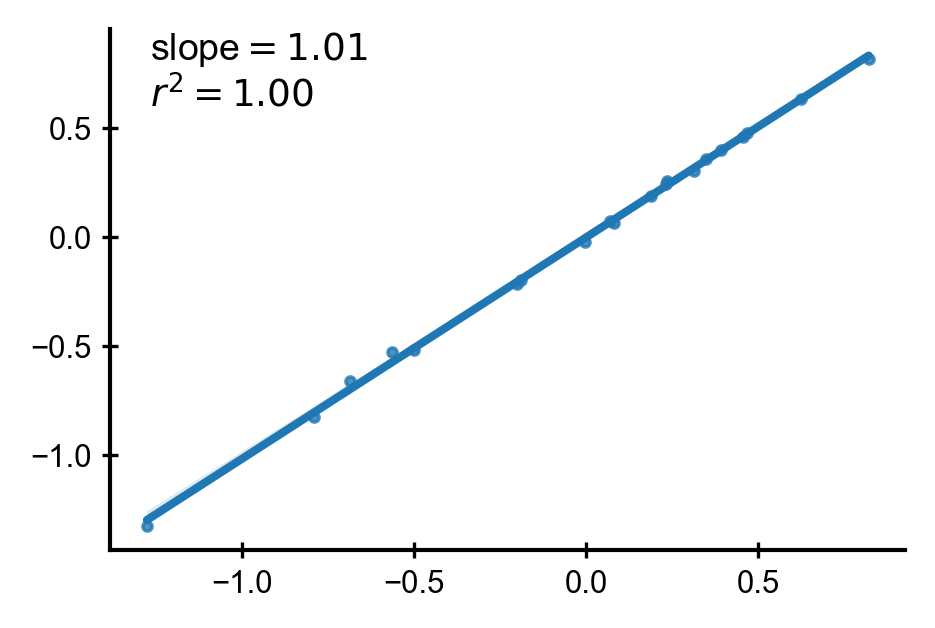

In [36]:
fig, ax = plt.subplots()
x = h
y = hi.mean(axis=0)
sns.regplot(x, y, ax=ax, scatter_kws=dict(s=5))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2, p_value, slope)
ax.text(0.05, 1.0, 'slope$={1:.2f}$\n$r^2={0:.2f}$'.format(r_value**2, slope),
        va='top', ha='left', transform=ax.transAxes)

In [37]:
for i in range(L):
    Jij[i, i, :, :] = 0.0
    for j in range(i+1, L):
        Jij[i, j, :, :] = 0.0

In [38]:
Jmean = 2*np.mean(Jij, axis=(0, 1))*(L**2/(L-1)**2)

0.8321432879285802 1.465528308024156e-148 1.0508870331746092


Text(0.05, 1.0, 'slope$=1.05$\n$r^2=0.83$')

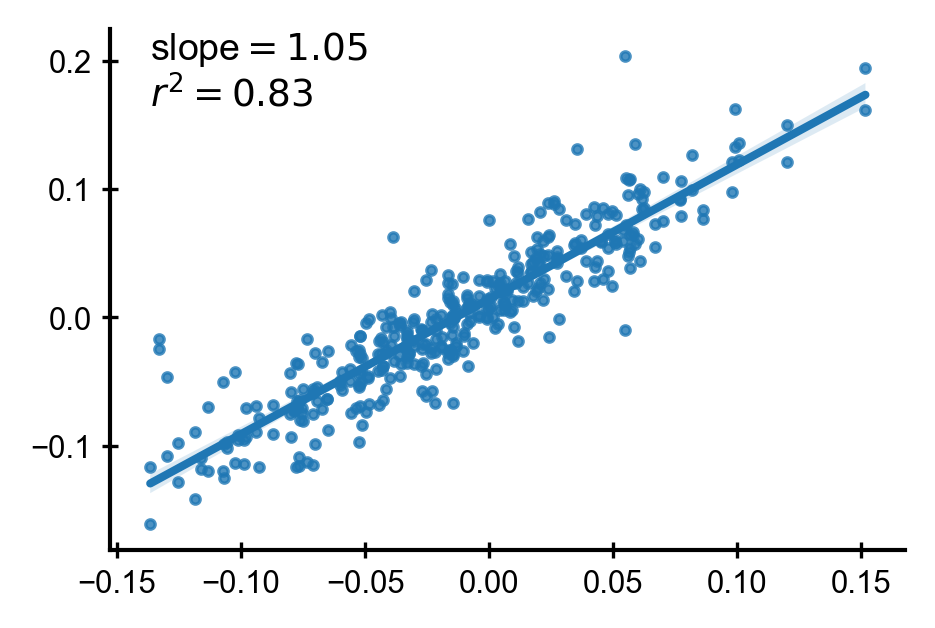

In [39]:
fig, ax = plt.subplots()
mask = ~np.eye(Jmean.shape[0], dtype=bool)
x = J[mask].flatten()
y = Jmean[mask].flatten()
sns.regplot(x, y, ax=ax, scatter_kws=dict(s=5))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2, p_value, slope)
ax.text(0.05, 1.0, 'slope$={1:.2f}$\n$r^2={0:.2f}$'.format(r_value**2, slope),
        va='top', ha='left', transform=ax.transAxes)

# Higher order couplings

In [29]:
aacounts = to_aacounts(sample_matrices['train'])
n3 = calc_n3(aacounts)

In [30]:
aacounts = to_aacounts(sample_matrices['test'])
n3_test = calc_n3(aacounts)

(array([  46.,  312.,  942., 1819., 2184., 1571.,  702.,  331.,   66.,
          27.]),
 array([-0.04584061, -0.03459433, -0.02334804, -0.01210175, -0.00085546,
         0.01039083,  0.02163711,  0.0328834 ,  0.04412969,  0.05537598,
         0.06662227]),
 <a list of 10 Patch objects>)

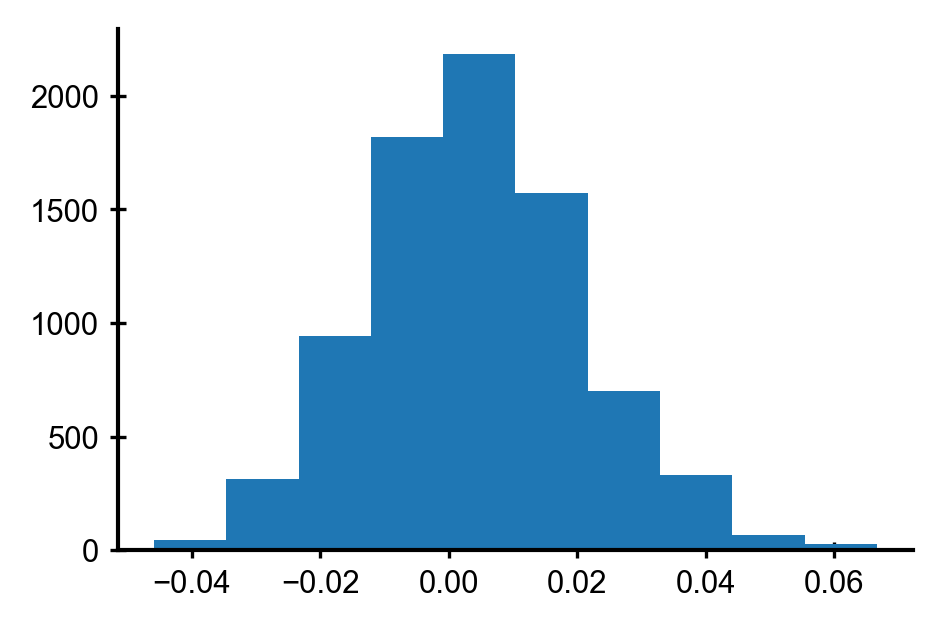

In [31]:
plt.hist(((n3 - n3_test)/n3).flatten())

0.9997411188135638 0.0 1.0063049544963758


Text(0.05, 1.0, 'slope$=1.01$\n$r^2=1.00$')

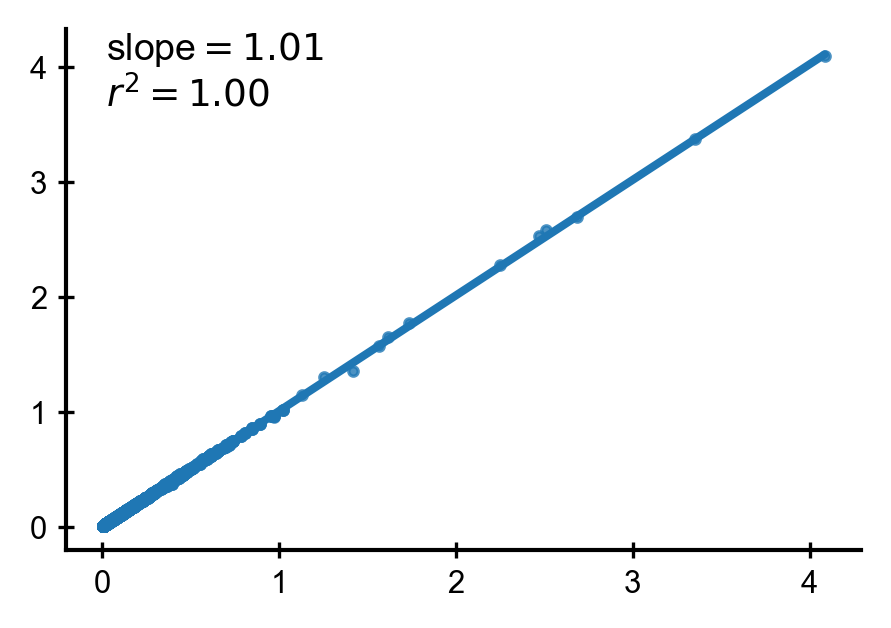

In [42]:
fig, ax = plt.subplots()
x = n3.flatten()
y = n3_test.flatten()
sns.regplot(x, y, ax=ax, scatter_kws=dict(s=5))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2, ap_value, slope)
ax.text(0.05, 1.0, 'slope$={1:.2f}$\n$r^2={0:.2f}$'.format(r_value**2, slope),
        va='top', ha='left', transform=ax.transAxes)

In [43]:
n3_model = calc_n3(aacounts_model)

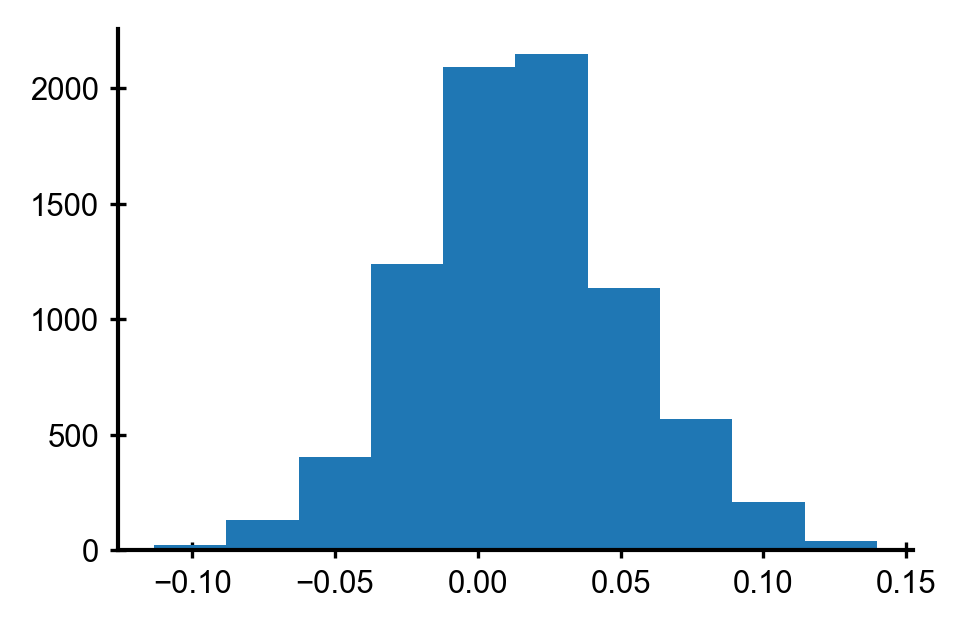

In [54]:
plt.hist(((n3_model - n3_test)/n3_test).flatten());

0.9987563441196157 0.0 0.9765281785895622


Text(0.05, 1.0, 'slope$=0.98$\n$r^2=1.00$')

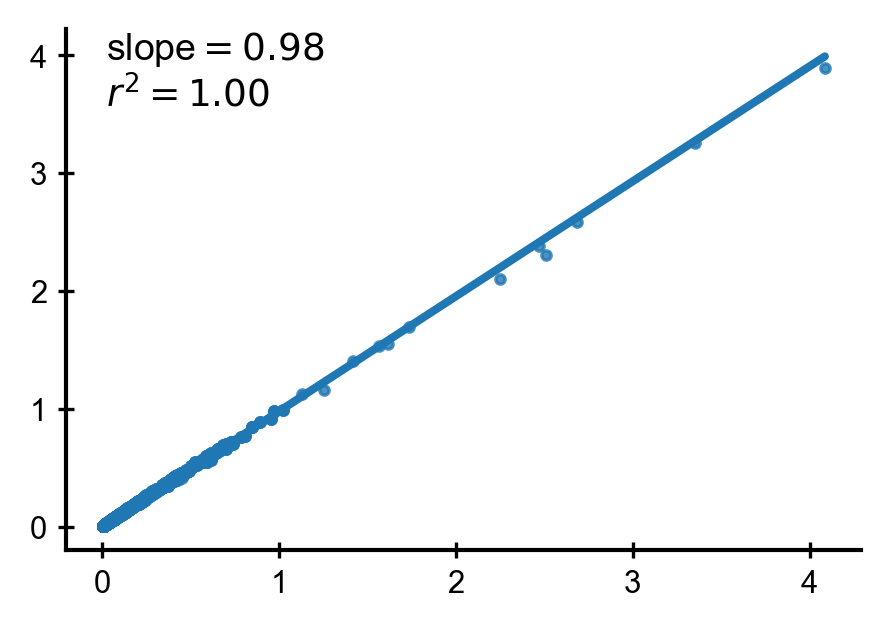

In [45]:
fig, ax = plt.subplots()
x = n3.flatten()
y = n3_model.flatten()
sns.regplot(x, y, ax=ax, scatter_kws=dict(s=5))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2, p_value, slope)
ax.text(0.05, 1.0, 'slope$={1:.2f}$\n$r^2={0:.2f}$'.format(r_value**2, slope),
        va='top', ha='left', transform=ax.transAxes)

In [46]:
@njit
def energy_third(x, h, J, J2):
    counts = aacounts_int_jit(x)
    q = len(h)
    e = 0
    for alpha in range(q):
        e -= h[alpha]*counts[alpha]
        for beta in range(alpha, q):
            e -= J[alpha, beta]*counts[alpha]*counts[beta]
            for gamma in range(beta, q):
                e -= J2[alpha, beta, gamma]*counts[alpha]*counts[beta]*counts[gamma]
    return e

In [51]:
def fit_third(n1, n2, n3, L, sampler, h=None, J=None, q=naminoacids,
            niter=1, epsilon=0.1, pseudocount=1.0,
            prng=None, output=False):
    """ sampler(x0, energy, jump, prng=prng): function returning samples from the distribution """
    if prng is None:
        prng = np.random
    if h is None:
        h = np.log(n1/L)
        h -= np.mean(h)
    else:
        h = h.copy()
    if J is None:
        J = np.zeros_like(n2)
    else:
        J = J.copy()
    J2 = np.zeros_like(n3)
    for iteration in range(niter):
        if output:
            print('iteration %g/%g'%(iteration+1,niter))

        x0 = global_jump(np.zeros(L), q, prng=prng)
        
        @njit
        def jump(x):
            return local_jump_jit(x, q)
        @njit
        def energy(x):
            return energy_third(x, h, J, J2)

        samples = sampler(x0, energy, jump)
        aacounts = to_aacounts(samples)

        n1_model = calc_n1(aacounts)
        n2_model = calc_n2(aacounts)
        n3_model = calc_n3(aacounts)
 
        h -= np.log(n1_model/n1)*epsilon
        J -= np.log(n2_model/n2)*epsilon
        J2 -= np.log(n3_model/n3)*epsilon
    return h, J, J2

In [55]:
prng = np.random
niter = 30
stepsize = 0.01
nsample = L
nsteps = 1e6
output = True

In [56]:
def sampler(*args, **kwargs):
    return mcmcsampler(*args, nsteps=nsteps, nsample=nsample, **kwargs)
h_third, J_third, J2_third = fit_third(n1, n2, n3, L,
                                       h=h, J=J,
                                       sampler=sampler, niter=niter,
                                       epsilon=stepsize, prng=prng, output=output)

iteration 1/30
iteration 2/30
iteration 3/30
iteration 4/30
iteration 5/30
iteration 6/30
iteration 7/30
iteration 8/30
iteration 9/30
iteration 10/30
iteration 11/30
iteration 12/30
iteration 13/30
iteration 14/30
iteration 15/30
iteration 16/30
iteration 17/30
iteration 18/30
iteration 19/30
iteration 20/30
iteration 21/30
iteration 22/30
iteration 23/30
iteration 24/30
iteration 25/30
iteration 26/30
iteration 27/30
iteration 28/30
iteration 29/30
iteration 30/30


(array([2., 6., 3., 3., 2., 1., 0., 2., 0., 1.]),
 array([0.00013418, 0.00137673, 0.00261928, 0.00386183, 0.00510439,
        0.00634694, 0.00758949, 0.00883205, 0.0100746 , 0.01131715,
        0.0125597 ]),
 <a list of 10 Patch objects>)

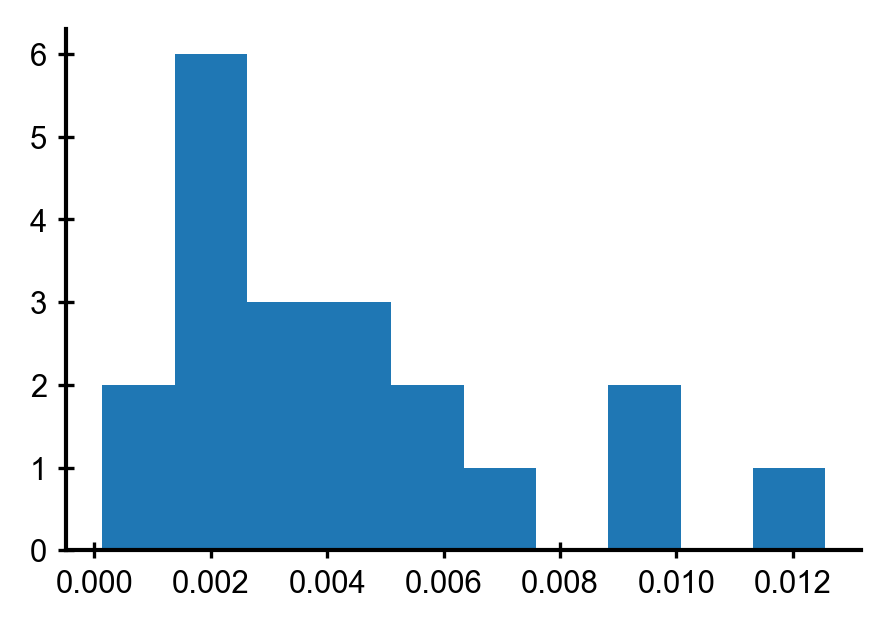

In [57]:
plt.hist([J2_third[i, i, i] for i in range(q)])

(array([  36.,   66.,  267.,  969., 2250., 2269., 1476.,  478.,  168.,
          21.]),
 array([-0.02482474, -0.01995712, -0.01508949, -0.01022186, -0.00535423,
        -0.00048661,  0.00438102,  0.00924865,  0.01411628,  0.0189839 ,
         0.02385153]),
 <a list of 10 Patch objects>)

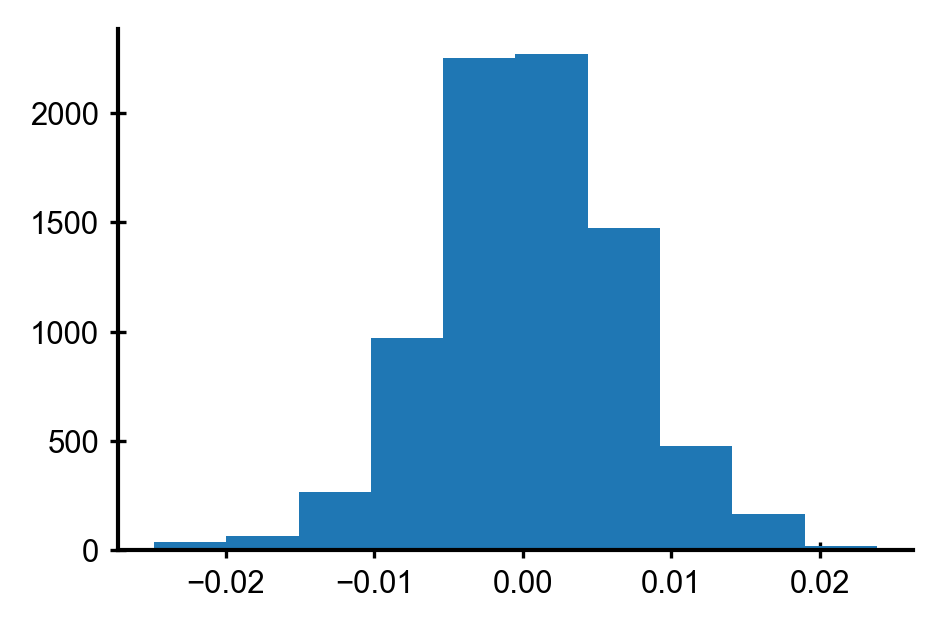

In [61]:
plt.hist(J2_third.flatten())

In [62]:
nsteps_generate = int(sample_matrices['train'].shape[0]*nsample)

@njit
def energy(x):
    return energy_third(x, h_third, J_third, J2_third)

@njit
def jump(x):
    return local_jump_jit(x, q)

x0 = prng.randint(q, size=L)
model_matrix = mcmcsampler(x0, energy, jump,
                           nsteps=nsteps_generate, nsample=nsample)

In [63]:
np.savetxt('data/model_third_matrix.csv.gz', model_matrix, fmt='%i')
np.savez('data/Human_third_L%g.npz'%L, h=h_third, J=J_third, J2=J2_third)

In [ ]:
aacounts = to_aacounts(sample_matrices['test'])
n3_model = calc_n3(aacounts, L)